# Offset Postprocessing
<br>

**Author:** Jack Logan

This notebook walks through the filtering steps to reduce noise used in `postprocess.py`. 
In this notebook, we filter speckle and noise from the offset outputs using a threshold and a localized Median Absolute Deviation filter.
After inpainting the missing values, we convert displacements to EPSG:3031 cartesian coordinates and scale to velocity in meters per year.

The steps are as follows:
1. Downsample to the effective resolution
2. Filter speckle
3. Inpaint values
4. Transform coordinate system
5. Convert to velocity

### Import Packages

In [1]:
import os

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from scipy.ndimage import median_filter, laplace
from shapely.geometry import Polygon

### Helper Functions

In [57]:
def plot_offsets(az, rg, amax=21):
    fig, axs = plt.subplots(1, 2, figsize=(10, 6), layout='constrained')
    ax1, ax2 = axs

    rg.plot(
        ax=ax1, vmin=-amax, vmax=amax, 
        cmap='RdBu_r', 
        add_colorbar=False
    )

    az.plot(
        ax=ax2, vmin=-amax, vmax=amax, 
        cmap='RdBu_r', 
        cbar_kwargs={'shrink':0.8, 'label':'Pixel Displacement'}
    )
    
    for ax in axs:
        ax.set_aspect('equal')
        ax.set_xlabel('x [m]')
        ax.set_ylabel('y [m]')
    
    return fig, axs

## Step 1: Downsample Resolution

The effective resolution is determined by the skip width and height.
With a skip size of 44 x 8, we achieve a resolution of ~ 100 m. 
ISCE2 outputs the files with a resolution of ~ 13 m, nearly an order of magnitude below our effective resolution.

To save memory and reduce computation costs, we can resample the data at our target resolution. 
In our processing, we are aiming for a grid resolution of 50 m. 

> We did a test between 50 m and 100 m effective resolution and found the 100 m resolution produced comparable results in approximately half the runtime.
> 
> Thus, our effective and target resolutions are not the same.

In [45]:
# Load in offsets from merged folder
off = xr.open_dataarray('offsets/20180807-20180819/merged/dense_offsets.nc', engine='rasterio')
# off = off.where(off != -1e4, np.nan)

# Interpolate to the coords of the fracture dataset
# bounds found manually, see external notebook, this saves memory.
xmin, xmax, nx = 1.345e6, 1.43e6, 1699
ymin, ymax, ny = 1.646e6, 1.76e6, 2279

off_interp = off.interp(
    coords={
    'x':np.linspace(xmin+50, xmax-50, nx),
    'y':np.linspace(ymin+50, ymax-50, ny)
    },
    method='nearest'
)

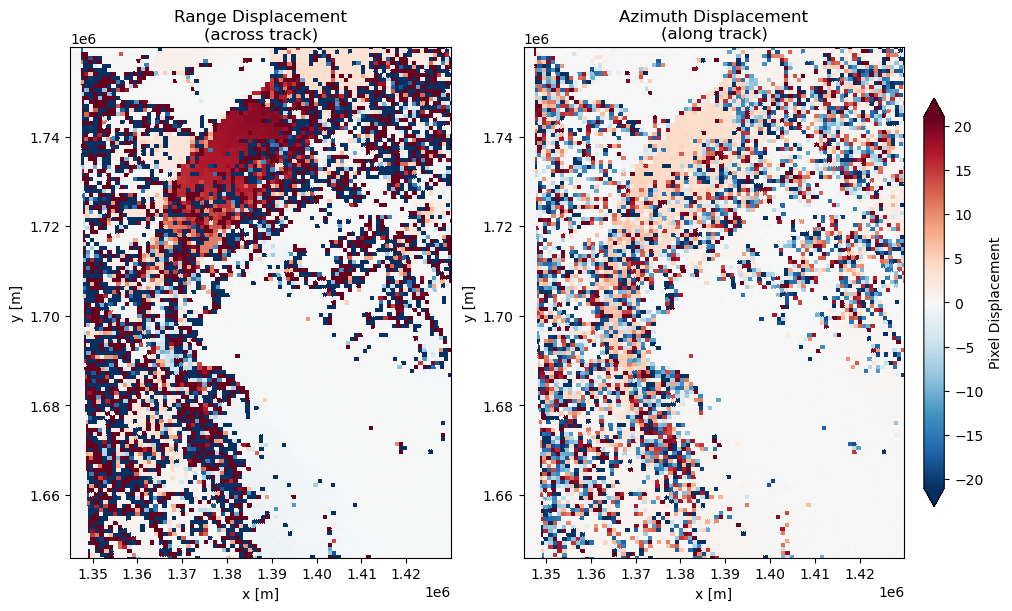

In [58]:
# Split bands into azimuth, range
az = off_interp.sel(band=1)
rg = off_interp.sel(band=2)

fig, axs = plot_offsets(az, rg)
ax1, ax2 = axs

ax1.set_title('Range Displacement\n(across track)')
ax2.set_title('Azimuth Displacement\n(along track)')

plt.show()

## Step 2: Filter Offsets

ISCE2 produces a lot of salt and pepper speckle. 
This happens frequently in low-velocity areas or when the correlation window cannot find a good match. 
We will filter using a two-step process:
1. apply an amplitude threshold above the maximum observed displacement,
2. apply a localized median absolute deviation filter.

### Amplitude Threshold

Histograms of the azimuth and range to properly apply a threshold.

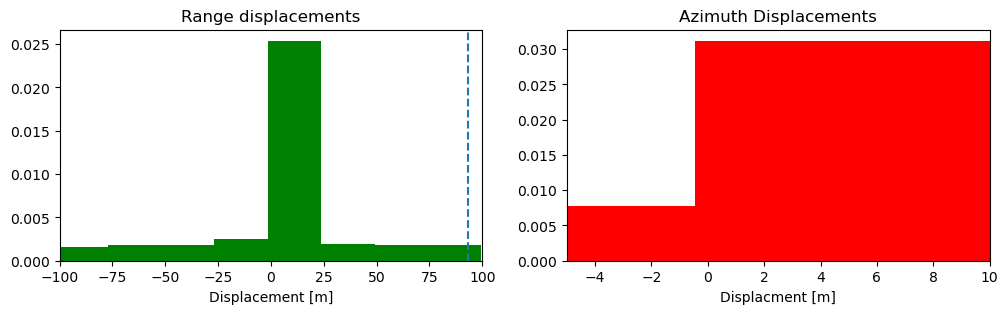

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))

rg.plot.hist(ax=ax1, bins=400, color='g', density=True)
ax1.axvline(rg.quantile(.988), ls='--', label='99th percentile')
ax1.axvline(rg.quantile(0.02), label='1st percentile')
ax1.set_title('Range displacements')
ax1.set_xlabel('Displacement [m]')
ax1.set_xlim(-100, 100)

az.plot.hist(ax=ax2, bins=400, color='r', density=True)
ax2.set_title('Azimuth Displacements')
ax2.set_xlabel('Displacment [m]')
ax2.axvline(az.quantile(.988), ls='--', label='99th percentile')
ax2.axvline(az.quantile(0.02), label='1st percentile')
ax2.set_xlim(-5, 10)

plt.show()

Looks like a highly asymmetric distribution

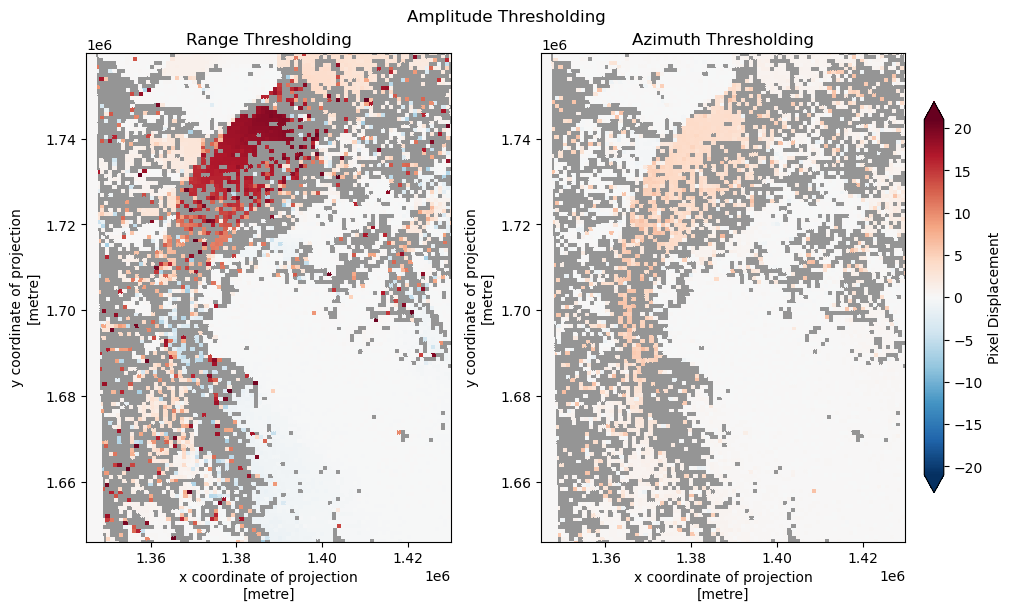

In [60]:
# . . Mask azimuth
az_max, az_min = 6.6, -1.5
thresh_mask_az = (az > az_max) + (az < az_min)

# . . Mask range
rg_max, rg_min = 21, -7
thresh_mask_rg = (rg > rg_max) + (rg < rg_min)

# . . Plot masks over data
fig, axs = plot_offsets(az, rg)
ax1, ax2 = axs

thresh_mask_rg.where(thresh_mask_rg, np.nan).plot(ax=ax1, add_colorbar=False, cmap='Greys')
ax1.set_title('Range')

thresh_mask_az.where(thresh_mask_az, np.nan).plot(ax=ax2, add_colorbar=False, cmap='Greys')
ax2.set_title('Azimuth')

plt.suptitle('Amplitude Thresholding')
plt.show()

### Median Absolute Deviation Filter

To localize the median absolute deviation, we use the following steps:

1. Median filter data with appropriate windows
2. Calculate residuals (difference between original and filtered data)
3. Calculate the MAD of the residuals
$$ MAD = median(|X_i - \tilde{X}|) $$
4. Exclude areas where $deviation > c * MAD$
    - Areas where the deviation is greater than the median deviation of the dataset, bye bye

In [ ]:
def mad_filter(arr, size=75, scale=5):
    # . . Apply median filter to the data
    med = xr.apply_ufunc(
        median_filter,
        arr,
        kwargs={'size':size}
    )
    
    # . . Compute difference between raw and filtered data
    diff = np.abs(arr - med)
    
    # . . Compute MAD of data
    mad = diff.median(skipna=True)
    
    # . . Threshold by a scale multiple of MAD
    mad_mask = (diff > (mad * scale))
    return mad_mask, med

# . . Apply MAD filter to each band
mad_mask_az, med_az = mad_filter(az)
mad_mask_rg, med_rg = mad_filter(rg)

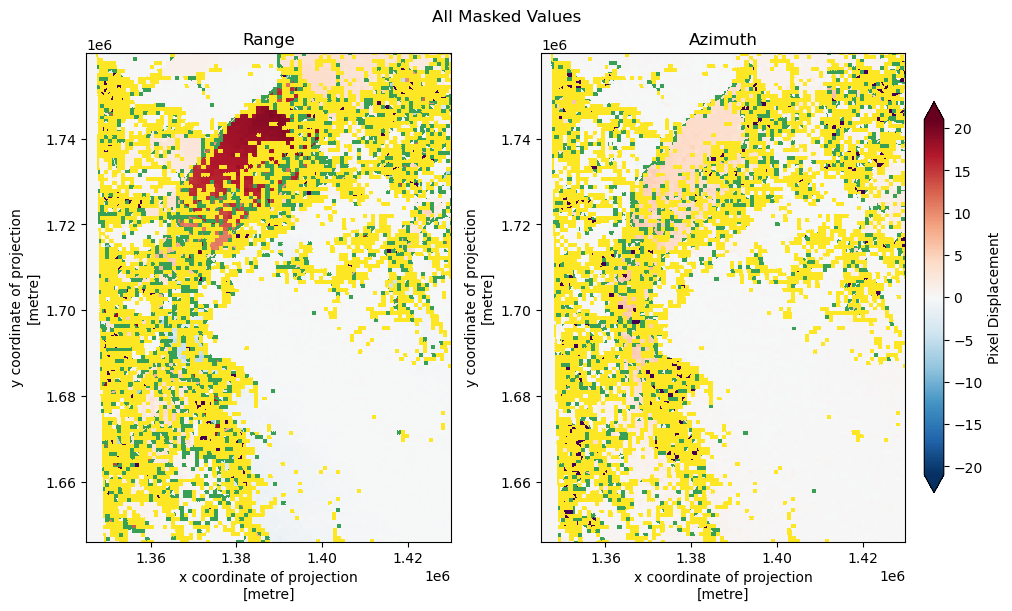

In [63]:
# . . Plot the masks
fig, axs = plot_offsets(az, rg)
ax1, ax2 = axs

thresh_mask_rg.where(thresh_mask_rg).plot(ax=ax1, cmap='Greys', vmax=1, vmin=0, add_colorbar=False)
mad_mask_rg.where(mad_mask_rg).plot(ax=ax1, cmap='Greens', vmax=1.5, vmin=0, add_colorbar=False)
mad_mask_rg.where(thresh_mask_rg).plot(ax=ax1, vmax=1, vmin=0, add_colorbar=False)  # Both masks

ax1.set_title('Range')

thresh_mask_az.where(thresh_mask_az).plot(ax=ax2, cmap='Greys', vmax=1, vmin=0, add_colorbar=False)
mad_mask_az.where(mad_mask_az).plot(ax=ax2, cmap='Greens', vmax=1.5, vmin=0, add_colorbar=False)
mad_mask_az.where(thresh_mask_az).plot(ax=ax2, vmax=1, vmin=0, add_colorbar=False)  # Both masks

ax2.set_title('Azimuth')

plt.suptitle('All Masked Values')
plt.show()

> The thresholded values are in black, the MAD values are in green. pixels discarded by both filters are in yellow.

### Mask Bad points

Remove the masked values and replace with the value of the large median filter from the MAD filtering step.

In [15]:
# . . Mask data, impute with median filtered value
full_mask_az = thresh_mask_az + mad_mask_az
az_masked = az.where(~full_mask_az, med_az)

full_mask_rg = thresh_mask_rg + mad_mask_rg
rg_masked = rg.where(~full_mask_rg, med_rg)

Text(0.5, 1.0, 'Azimuth')

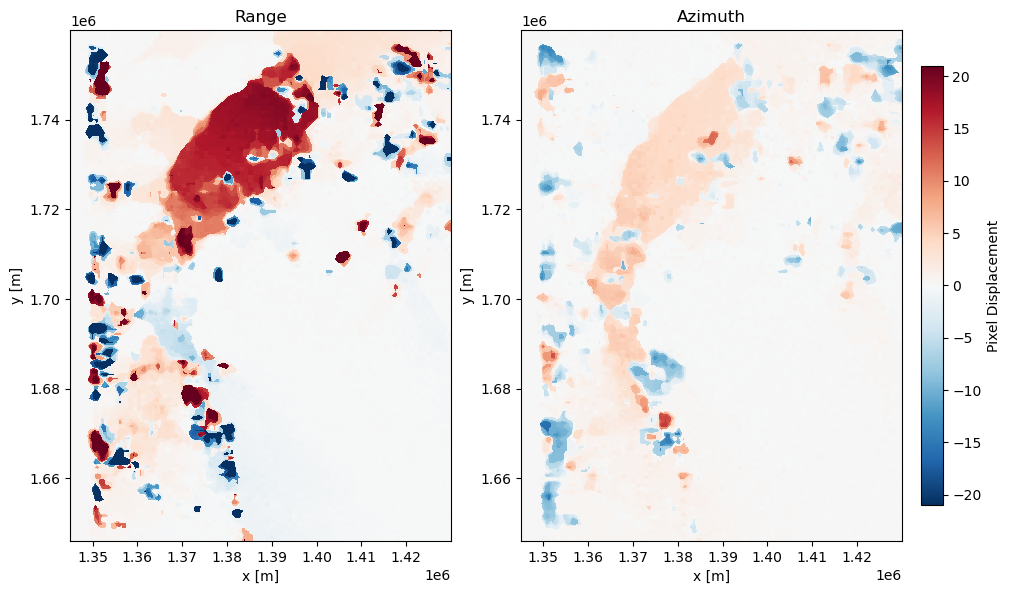

In [65]:
fig, axs = plot_offsets(az_masked, rg_masked)
ax1, ax2 = axs

ax1.set_title('Range')
ax2.set_title('Azimuth')

plt.suptitle('Masked offsets')

## Step 3: Interpolate masked values

We replace the masked values using harmonic inpainting. 
This method is also called a laplacian infill. 
It uses the laplacian to smooth sharp features while preserving gradients in large scale fields, ideal for this scenario.

Typically, the interpolation would fill on 0 values, but for this case we set masked values to the median filter. 
This is because the method often failed to fill large data gaps.
Using the median filter value fixed this issue.

In [67]:
def lap_infill(arr, med, mask):
    filled = arr.copy().values
    median_filtered = med.copy().values
    lap_mask = mask.copy().values
    
    filled[lap_mask] = median_filtered[lap_mask]
    
    for _ in range(1500):
        lap = laplace(filled, mode='nearest')
        filled[lap_mask] += 0.2 * lap[lap_mask]
    
    return xr.DataArray(
        filled,
        dims=arr.dims,
        coords=arr.coords
    )

az_filled = lap_infill(az_masked, med_az, full_mask_az)
rg_filled = lap_infill(rg_masked, med_rg, full_mask_rg)

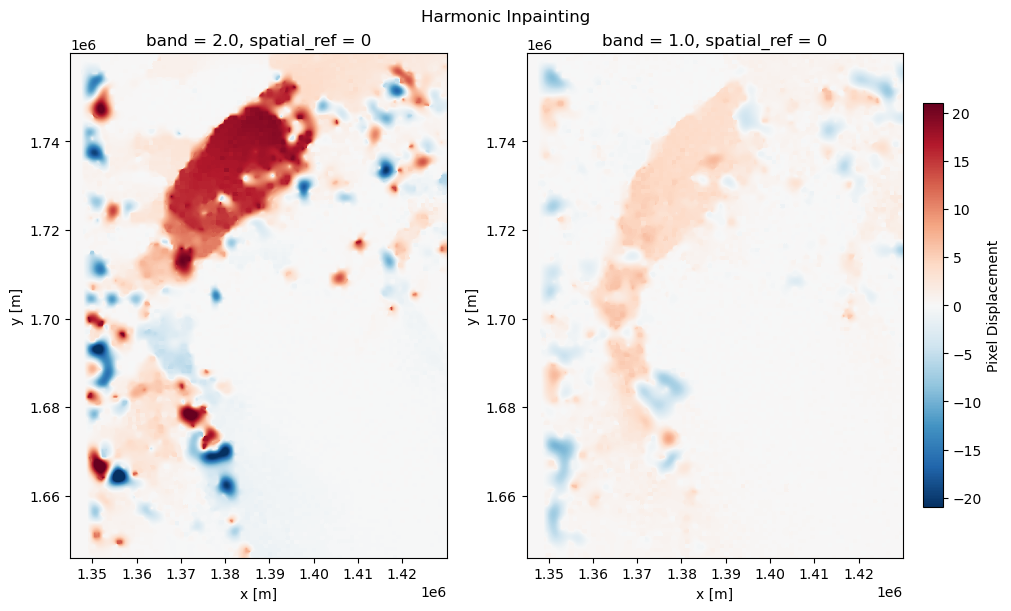

In [68]:
fig, axs = plot_offsets(az_filled, rg_filled)

ax2.set_title('Range')
ax2.set_title('Azimuth')

plt.suptitle('Harmonic Inpainting')
plt.show()

## Step 4: Transform coordinates

Now we will convert from from azimuth-range-coordingates to EPSG:3031 xy-coordinates. To do this, we need to get the satellites heading in reference to the grid system. We will do that via the bounding box.

From one of the SAFE zip files, you can extract the bounding box of the Sentinel-1 frame. For Shirase Glacier, the WKT is:
```
'POLYGON ((1261309.4671252735 1775874.4512153463, 1513081.2203376407 1778324.8702692143, 1513619.2870697696 1592810.3581539085, 1262580.7035495376 1591567.5236746788, 1261309.4671252735 1775874.4512153463))'
```

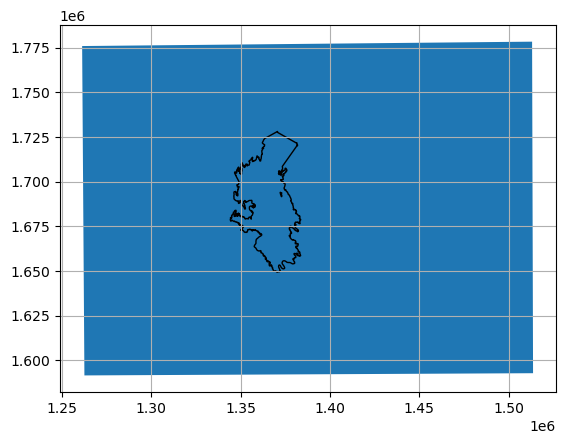

In [18]:
# . . Shirase Glacier shapefile
shirase = gpd.read_file('/home/jovyan/shared-readwrite/BlueIce/Blue_ice_data/shirase.shp')

# . . Make GeoDataFrame of bounding box
wkt = 'POLYGON ((1261309.4671252735 1775874.4512153463, 1513081.2203376407 1778324.8702692143, 1513619.2870697696 1592810.3581539085, 1262580.7035495376 1591567.5236746788, 1261309.4671252735 1775874.4512153463))'
s1_frame = gpd.GeoSeries.from_wkt(
    [wkt],
    crs='EPSG:3031'
)

# . . Plot for comparison
fig, ax = plt.subplots()

s1_frame.to_crs(3031).plot(ax=ax)
shirase.plot(ax=ax, fc='none')
plt.grid()
plt.show()

Now we can calculate the satellite's heading (in radians) from the positive x-axis.

In [19]:
def get_satellite_geometry(wkt):
    """Get satellite angle in EPSG:3031 from preview KML file"""
    bbox = gpd.GeoSeries.from_wkt(
        [wkt],
        crs='EPSG:3031'
    )

    # Get coordinates of bbox
    coords = list(bbox.geometry[0].exterior.coords)
    x1, y1 = coords[0]
    x2, y2 = coords[1]

    # Compute angle in radians
    return np.arctan2(y2-y1, x2-x1)

heading = get_satellite_geometry(wkt)

Before we rotate the displacements to cartesian coordinates, we need to scale the offset values. They are currently given as number of pixels in the azimuth and range directions. To get the displacement in meters, we must scale by the directional resolution:

$$y = (\text{azimuth offset}) \times 14.1 \text{ m}, \quad x = (\text{range offset}) * \frac{2.3}{\sin{\theta}} \text{ m}.$$

Then, we can do a coordinate transformation to get the offsets in xy-coordinates.

In [24]:
# . . Multiply offsets by resolution to get disp in meters
az_filled *= 14.1
rg_filled *= 2.3 / np.sin(np.radians(38.3)) # Ground-range (only horizontal)

# . . S1 orbit heading with reference to EPSG:3031 grid
heading = 0.0097

# . . Coordinate transformation
x_offsets = np.cos(heading) * rg_filled - np.sin(heading) * az_filled
y_offsets = np.cos(heading) * az_filled + np.sin(heading) * rg_filled

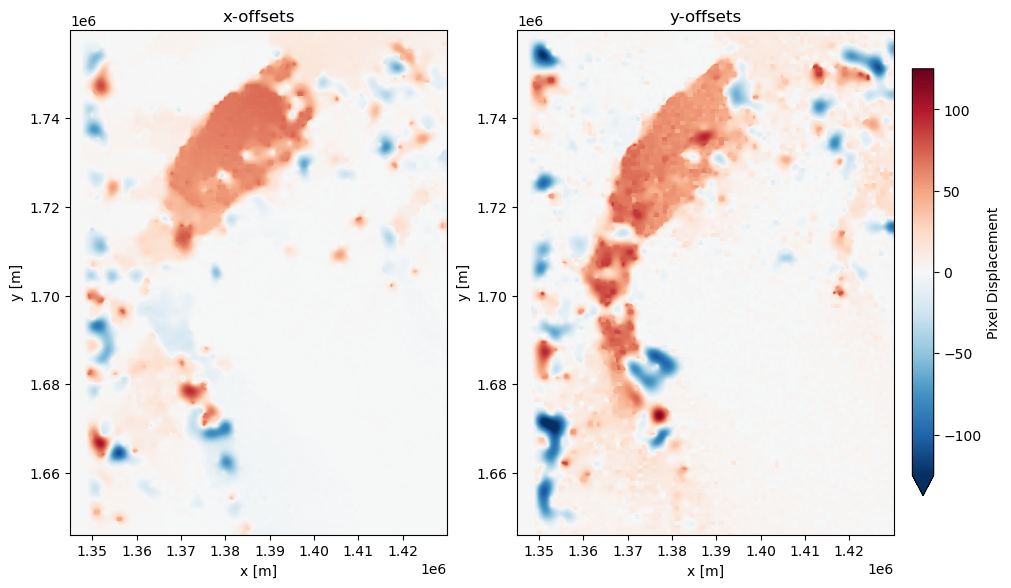

In [71]:
fig, axs = plot_offsets(y_offsets, x_offsets, amax=125)
ax1, ax2 = axs

ax1.set_title('x-offsets')
ax2.set_title('y-offsets')

plt.show()

## Step 5: Convert to velocity

Now we have our displacements in meters. This occurred over a 12 day span, so to scale to velocity in meters per year, we have to do a simple unit conversion.

Divide by the number of days between satellite passes to get velocity in meters per day, then scale by 365.24 days per year.

In [72]:
# Convert to meters / year
vx = x_offsets * 365.24 / 12
vy = y_offsets * 365.24 / 12

# Unit conversion to velocity, saved in dataset
velocity = xr.Dataset({
    'vx':vx,
    'vy':vy,
    'vv':np.sqrt(vx**2 + vy**2)
})

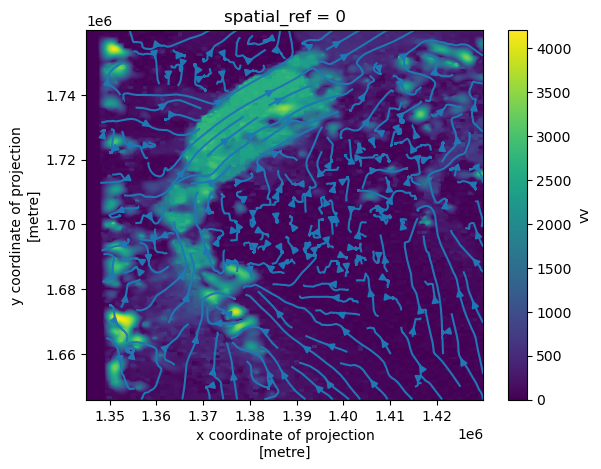

In [73]:
fig, ax = plt.subplots()

velocity.vv.plot(ax=ax)
velocity.plot.streamplot(
    'x', 'y',
    'vx', 'vy',
    ax=ax
)

plt.show()

## Postprocess all Offsets

After all of your offsets have been generated, you can run the `preprocess.py` script from the command line. 
This script is designed to combine all processed outputs into one dataset, then perform all the postprocessing steps in parallel along the time dimensions. 

I recommend fine tuning your filtering parameters in this notebook, then editing the script to reflect the parameters for your data.
Before running the script, make sure you change the axis interpolation limits in lines 10 and 11:
```python
# . . Interpolation params
xmin, xmax, nx = 1.345e6+50, 1.43e6-50, 1699
ymin, ymax, ny = 1.646e6+50, 1.76e6-50, 2279
```
and the thresholding values in lines 102 and 103:
```python
# Make mask for Thresholding
az_mask = (ds['azimuth'] > (.55)) | (ds['azimuth'] < (-.125))
rg_mask = (ds['range'] > (1.75)) | (ds['range'] < (-.58))
```
but note that these thresholds are normalized to pixels per day.

Once these changes have been made, from run the `offets` directory, run:
```bash
python postprocess.py
```